# Score-Differenz: Data-Professionals vs. Durchschnittseinkommen

### Wo lohnen sich Data-Jobs besonders?

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

In [38]:
# Daten laden
cost_of_living_df = pd.read_csv("../output/CostOfLivingAPI.csv")
scraped_jobs_df = pd.read_csv("../output/ScrapedJobOffersAllCleaned.csv")

## Brutto -> Netto Umrechnung

In [39]:
scraped_jobs_df["annual_salary_netto"] = scraped_jobs_df.apply(
    lambda row: row["annual_salary"] * 0.62 if row["country"].lower() == "austria"
    else row["annual_salary"] * 0.62 if row["country"].lower() == "germany"
    else None,
    axis=1
)

## Städte und Länder vereinheitlichen

In [40]:
scraped_jobs_df["city"] = scraped_jobs_df["city"].str.strip().str.title()
scraped_jobs_df["country"] = scraped_jobs_df["country"].str.strip().str.lower()
cost_of_living_df["city"] = cost_of_living_df["city"].str.strip().str.title()
cost_of_living_df["country"] = cost_of_living_df["country"].str.strip().str.lower()

## Durchschnittliches Netto-Datajob-Gehalt pro Stadt

In [41]:
avg_netto_scraped = scraped_jobs_df.groupby(["city", "country"], as_index=False)[
    "annual_salary_netto"].mean().rename(columns={"annual_salary_netto": "avg_datajob_netto"})

## Lebenshaltungskosten berechnen

In [42]:
cost_of_living_df["total_costs"] = (
        cost_of_living_df["apt1_city_centre"] +
        cost_of_living_df["ticket_monthly"] +
        cost_of_living_df["utilities"] +
        cost_of_living_df["internet"]
)
cost_of_living_df["score_allgemein"] = cost_of_living_df["net_salary"] / cost_of_living_df["total_costs"]

In [43]:
# Merge der beiden Quellen
merged_df = pd.merge(cost_of_living_df, avg_netto_scraped, how="inner", on=["city", "country"])

## Monatsberechnung nach Land

In [44]:
def compute_monthly_netto(row):
    if row["country"] == "austria":
        return row["avg_datajob_netto"] / 12
    elif row["country"] == "germany":
        return row["avg_datajob_netto"] / 12
    else:
        return None

merged_df["monthly_datajob_netto"] = merged_df.apply(compute_monthly_netto, axis=1)

## Score für Datajob auf Monatsbasis

In [45]:
merged_df["score_datajob"] = merged_df["monthly_datajob_netto"] / merged_df["total_costs"]

## Ranking-Tabelle

In [46]:
ranking_df = merged_df.sort_values("score_datajob", ascending=False)[[
    "city", "country", "net_salary", "monthly_datajob_netto", "total_costs", "score_allgemein", "score_datajob"
]]
display(ranking_df)

,city,country,net_salary,monthly_datajob_netto,total_costs,score_allgemein,score_datajob
7,Frankfurt,germany,3666.67,3866.564664,1067.92,3.433469,3.620650
6,Hamburg,germany,2540.87,3852.466056,1340.04,1.896115,2.874889
2,Linz,austria,2229.89,2781.900076,1004.98,2.218840,2.768115
8,Köln,germany,2628.25,3959.456871,1498.92,1.753429,2.641540
1,Graz,austria,2551.07,2649.356535,1117.28,2.283286,2.371256
4,Berlin,germany,2891.64,3643.464263,1641.40,1.761691,2.219730
5,München,germany,3382.65,4013.150014,1971.09,1.716132,2.036005
0,Wien,austria,2641.54,2790.664341,1393.29,1.895901,2.002931
3,Salzburg,austria,2763.55,2506.404706,1548.90,1.784202,1.618184


## Visualisierung der Top 10

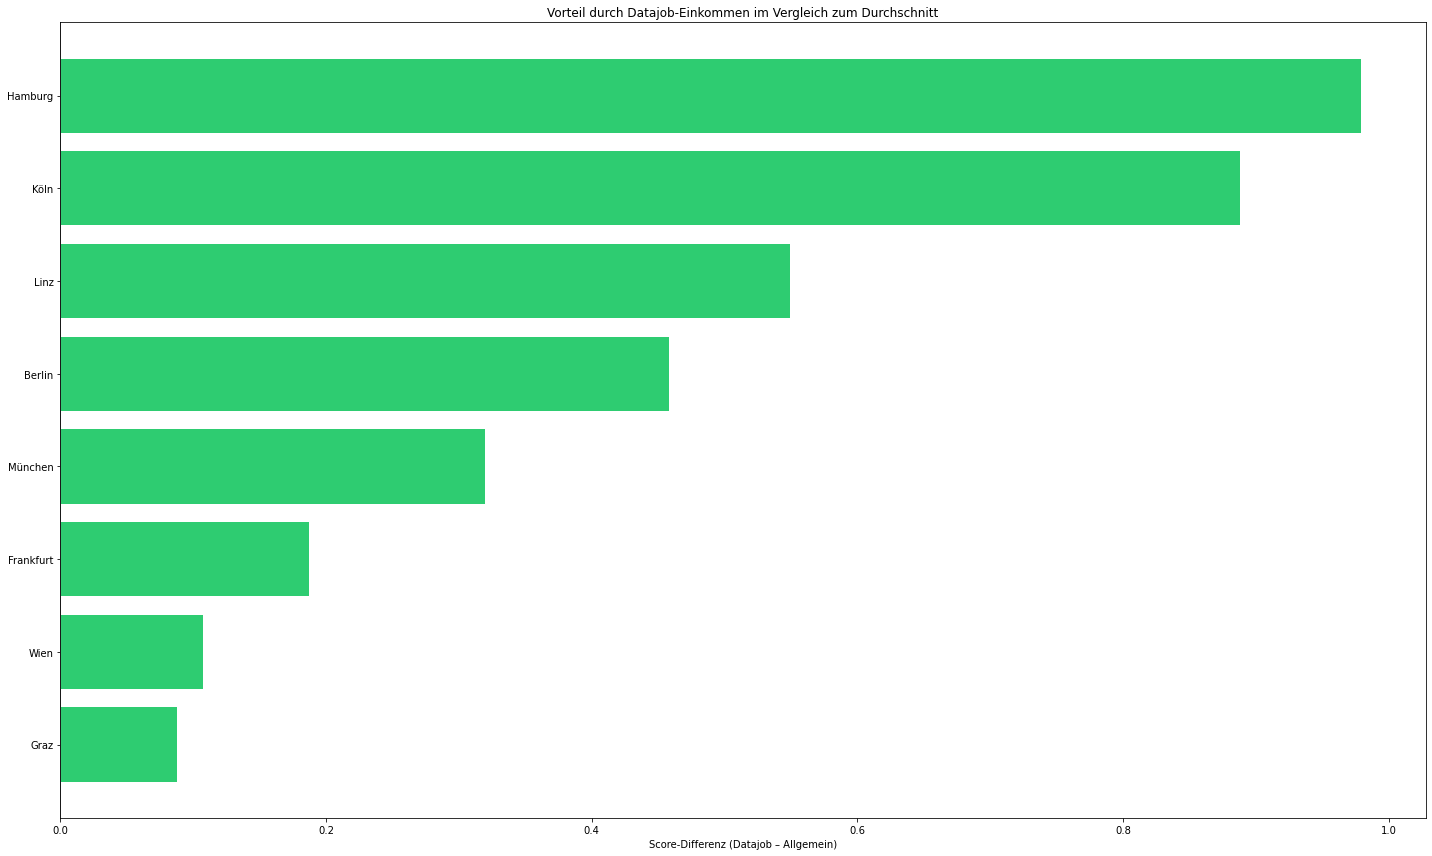

In [47]:
# Differenz berechnen
merged_df["score_diff"] = merged_df["score_datajob"] - merged_df["score_allgemein"]

# Sortiert nach größter positiver Differenz
top_diff = merged_df.sort_values("score_diff", ascending=False).head(8)

# Farben nach Vorzeichen
colors = ['#2ECC71' if val >= 0 else '#E74C3C' for val in top_diff["score_diff"]]

# Plot
plt.figure(figsize=(20, 12))
plt.barh(top_diff["city"], top_diff["score_diff"], color=colors)
plt.xlabel("Score-Differenz (Datajob – Allgemein)")
plt.title("Vorteil durch Datajob-Einkommen im Vergleich zum Durchschnitt")
plt.axvline(0, color='gray', linewidth=1)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

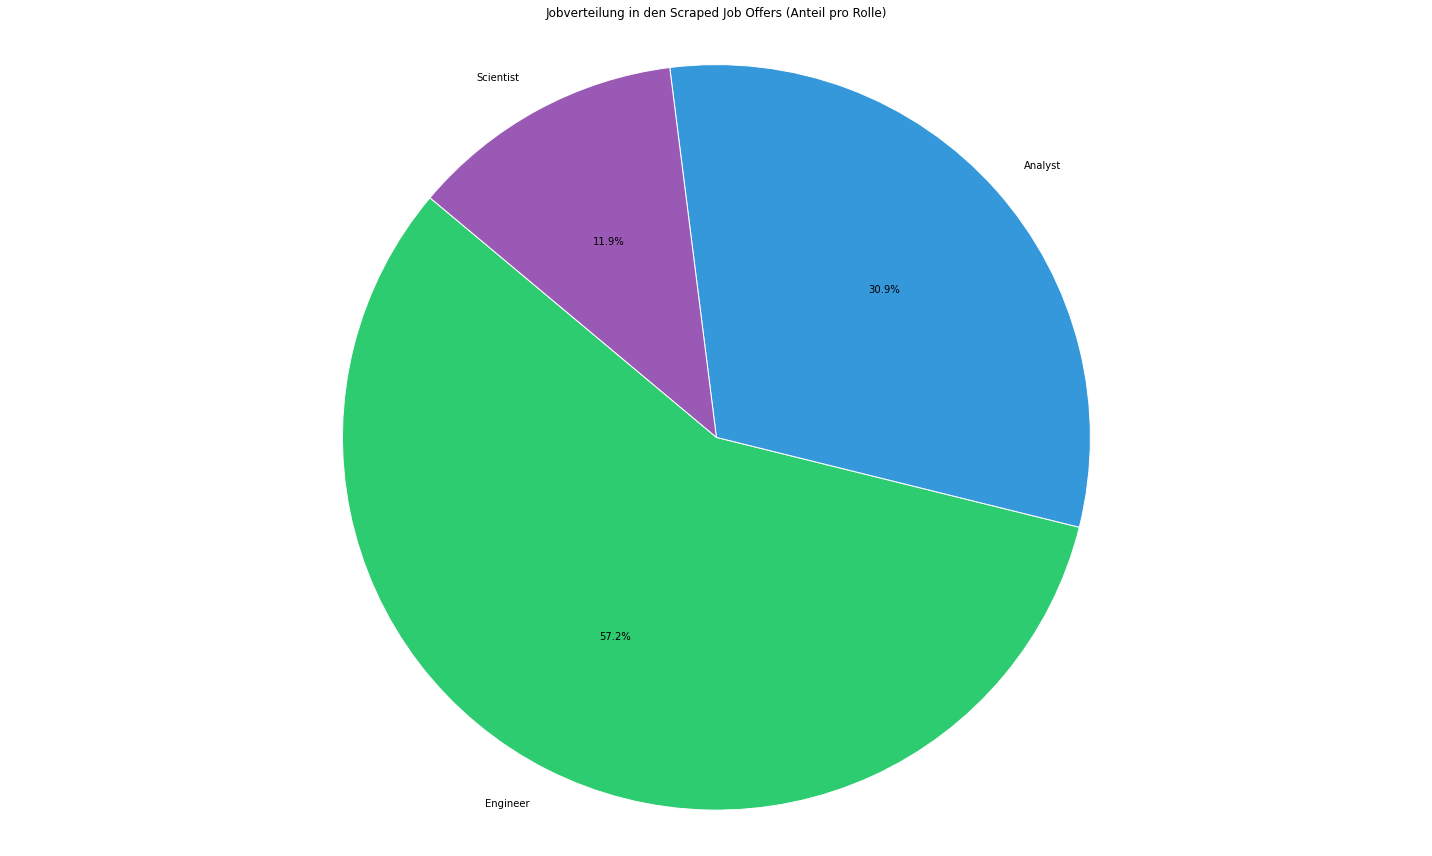

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Scraped-Daten laden
scraped_jobs_df = pd.read_csv("../output/ScrapedJobOffersAllCleaned.csv")

# Rollenklassifikation
def classify_role(title):
    title = str(title).lower()
    if "analyst" in title:
        return "Analyst"
    elif "scientist" in title:
        return "Scientist"
    elif "engineer" in title:
        return "Engineer"
    else:
        return "Other"

# Jobrolle zuweisen
scraped_jobs_df["job_role"] = scraped_jobs_df["job_title"].apply(classify_role)

# Zählen
role_counts = scraped_jobs_df["job_role"].value_counts()
roles = ["Engineer", "Analyst", "Scientist"]
counts = [role_counts.get(r, 0) for r in roles]

# Visualisierung als Tortendiagramm
colors = ["#2ECC71", "#3498DB", "#9B59B6"]

plt.figure(figsize=(20, 12))
plt.pie(
    counts,
    labels=roles,
    colors=colors,
    autopct='%1.1f%%',
    startangle=140,
    wedgeprops={'edgecolor': 'white'}
)
plt.title("Jobverteilung in den Scraped Job Offers (Anteil pro Rolle)")
plt.axis("equal")  # Kreisform beibehalten
plt.tight_layout()
plt.show()
